## Create and test ion channel model

In [1]:
from experiments.ina_sakakibara import (sakakibara_iv,
                                        sakakibara_iv_Nao2 ,
                                        sakakibara_iv_Nao5 ,
                                        sakakibara_iv_Nao20 ,
                                        sakakibara_act,
                                        sakakibara_inact,
                                        sakakibara_inact_kin_1,
                                        sakakibara_inact_kin_2,
                                        sakakibara_recov,
                                        sakakibara_recov_kin)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyabc import Distribution, RV
import os, tempfile
import logging
from pyabc.populationstrategy import AdaptivePopulationSize, ConstantPopulationSize
from ionchannelABC import theoretical_population_size
from pyabc import ABCSMC
from pyabc.epsilon import MedianEpsilon
from pyabc.sampler import MulticoreEvalParallelSampler, SingleCoreSampler
from ionchannelABC import IonChannelDistance, EfficientMultivariateNormalTransition, IonChannelAcceptor
from pyabc import History
from ionchannelABC import plot_sim_results
import seaborn as sns
from ionchannelABC import plot_parameters_kde
from ionchannelABC.experiment import setup

INFO:myokit:Loading Myokit version 1.28.4


In [2]:
modelfile = 'models/nygren_Na.mmt'

In [87]:
observations, model, summary_statistics = setup(modelfile,
                                                sakakibara_iv_Nao2 ,
                                                sakakibara_iv_Nao5 ,
                                                sakakibara_iv_Nao20 ,
                                                sakakibara_act,
                                                sakakibara_inact,
                                                sakakibara_inact_kin_1,
                                                sakakibara_inact_kin_2,
                                                sakakibara_recov,
                                                sakakibara_recov_kin)

In [88]:
assert len(observations)==len(summary_statistics(model({})))

## Set limits and generate uniform initial priors

In [89]:

# 
#'membrane.Cm' : (0.0001,1), # keep it off 

limits = {'ina.s1' : (0,1),
          
          'ina.P_Na' : (0.000001,0.05),
          'ina.q1': (80,120),
          'ina.q2': (0,20),
          'ina.r1': (25,75),
          'ina.r2': (-25,25),
          'ina.q3': (0,20),
          'ina.q4': (20,80),
          'ina.q5': (-25,25),
          'ina.q6': (0,20),
          'ina.q7': (0,20),
          'ina.q8': (0,20),
          'ina.r3': (0,1),
          'ina.r4': (0,100),
          'ina.r5': (0,100),
          'ina.r6': (0,0.01)}
"""
limits = {'ina.P_Na' : (0.000001,0.05),
          'ina.q1': (0,100),
          'ina.q2': (0,100),
          'ina.r1': (0,100),
          'ina.r2': (-50,50)}
"""
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

## Run ABC calibration

In [90]:
db_path = ("sqlite:///" +
           os.path.join(tempfile.gettempdir(), "nygren_ina_testing.db"))

In [91]:
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)

In [92]:
pop_size = theoretical_population_size(2, len(limits))
print("Theoretical minimum population size is {} particles".format(pop_size))

Theoretical minimum population size is 65536 particles


In [93]:

abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 exp_id=list(observations.exp_id),
                 variance=list(observations.variance),
                 delta=0.05),
             population_size=ConstantPopulationSize(10000), #Small pop to test
             summary_statistics=summary_statistics,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(initial_epsilon=20),
             sampler=MulticoreEvalParallelSampler(n_procs=12),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {'0': 0.9617686805272357, '1': 0.9617686805272357, '2': 0.9617686805272357, '3': 0.9617686805272357, '4': 0.9617686805272357, '5': 0.9617686805272357, '6': 0.9617686805272357, '7': 0.9617686805272357, '8': 0.9617686805272357, '9': 0.9617686805272357, '10': 0.9617686805272357, '11': 0.9617686805272357, '12': 0.9617686805272357, '13': 0.9617686805272357, '14': 0.9617686805272357, '15': 0.9617686805272357, '16': 0.9617686805272357, '17': 0.9617686805272357, '18': 0.9617686805272357, '19': 0.9617686805272357, '20': 0.9617686805272357, '21': 0.9617686805272357, '22': 0.9617686805272357, '23': 0.9617686805272357, '24': 0.9617686805272357, '25': 0.9617686805272357, '26': 0.9617686805272357, '27': 0.9617686805272357, '28': 0.9617686805272357, '29': 0.9617686805272357, '30': 0.9617686805272357, '31': 0.9617686805272357, '32': 0.9617686805272357, '33': 0.9617686805272357, '34': 0.9617686805272357, '35': 0.9617686805272357, '36': 0.9617686805272357, '37': 0.96176868

In [94]:
obs = observations.to_dict()['y']
obs = {str(k): v for k, v in obs.items()}

In [95]:
#abc.load(db_path,42)

In [96]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=50, start_time=2019-08-13 14:24:30.859443, end_time=None)>


In [97]:
history = abc.run(minimum_epsilon=0.1, max_nr_populations=10, min_acceptance_rate=0.005)

INFO:ABC:t:0 eps:20
DEBUG:ABC:now submitting population 0
DEBUG:ABC:population 0 done
DEBUG:ABC:
total nr simulations up to t =0 is 120122
DEBUG:Epsilon:new eps, t=1, eps=13.335024096810228
INFO:ABC:t:1 eps:13.335024096810228
DEBUG:ABC:now submitting population 1
DEBUG:ABC:population 1 done
DEBUG:ABC:
total nr simulations up to t =1 is 152071
DEBUG:Epsilon:new eps, t=2, eps=9.276547468169158
INFO:ABC:t:2 eps:9.276547468169158
DEBUG:ABC:now submitting population 2
DEBUG:ABC:population 2 done
DEBUG:ABC:
total nr simulations up to t =2 is 180696
DEBUG:Epsilon:new eps, t=3, eps=7.301738266202351
INFO:ABC:t:3 eps:7.301738266202351
DEBUG:ABC:now submitting population 3
DEBUG:ABC:population 3 done
DEBUG:ABC:
total nr simulations up to t =3 is 205482
DEBUG:Epsilon:new eps, t=4, eps=6.528465098199958
INFO:ABC:t:4 eps:6.528465098199958
DEBUG:ABC:now submitting population 4
DEBUG:ABC:population 4 done
DEBUG:ABC:
total nr simulations up to t =4 is 229913
DEBUG:Epsilon:new eps, t=5, eps=6.074927599

# Results analysis

In [59]:
#history.all_runs()

/apps/anaconda3/lib/python3.7/site-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '
/apps/anaconda3/lib/python3.7/site-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '
/apps/anaconda3/lib/python3.7/site-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '
/apps/anaconda3/lib/python3.7/site-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '
/apps/anaconda3/

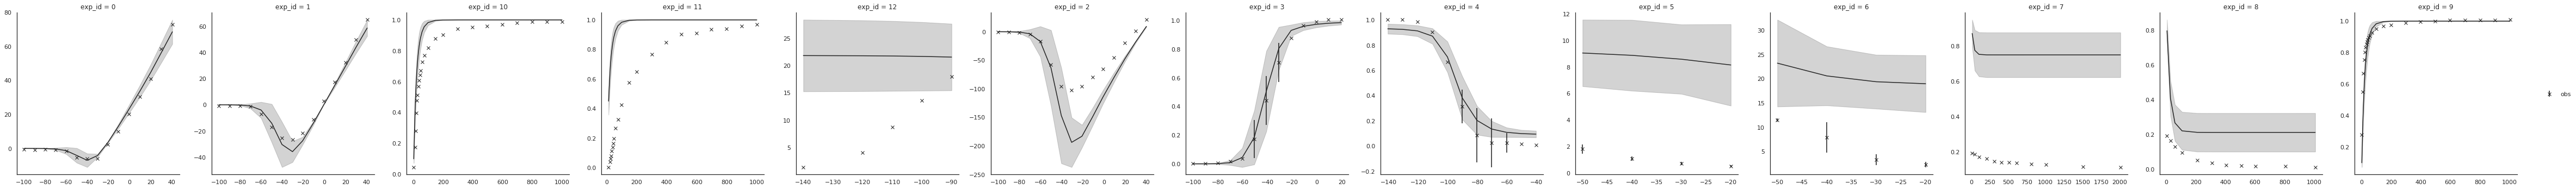

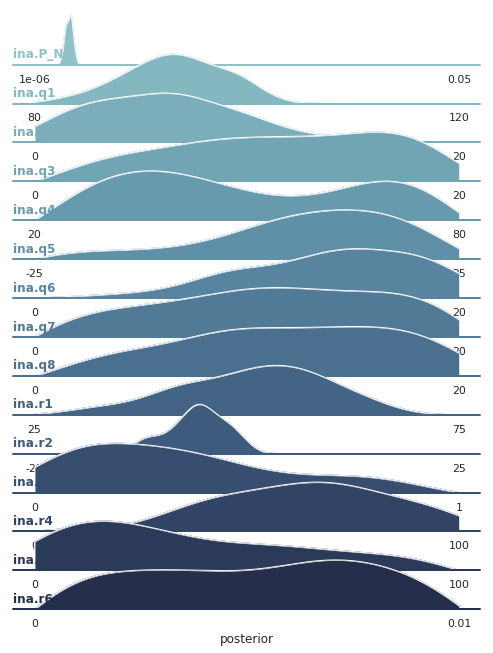

In [98]:
history = History(db_path)
history.id = 49
df, w = history.get_distribution(m=0)

grid1 = plot_sim_results(modelfile,sakakibara_iv_Nao2 ,
                                                sakakibara_iv_Nao5 ,
                                                sakakibara_iv_Nao20 ,
                                                sakakibara_act,
                                                sakakibara_inact,
                                                sakakibara_inact_kin_1,
                                                sakakibara_inact_kin_2,
                                                sakakibara_recov,
                                                sakakibara_recov_kin, df=df, w=w) 
grid2 = plot_parameters_kde(df, w, limits, aspect=12,height=0.6)

In [101]:
grid2.savefig('results/ina_nygren_posterior_sakakibara_Q10_pop_10000.pdf')
grid1.savefig('results/ina_nygren_experiments_sakakibara_Q10_pop_10000.pdf')